Obviously, we want to BOTH maximize accurate predictions AND minimize average error. The training error function for the set of inputs and outputs $(X_i, y_i)_{i = 1}^n$ is the following:

$Loss = \frac1n \sum_{i = 1}^n \left[ |(\hat{f}(X_i) - y_i)| \left( 1 + K(1 - \delta_{sign[\hat{f}(X_i)], sign(y_i)}) \right) \right]$ 

Determining the value of K is of utmost importance because it determines how heavily we weight wrong guesses, so this file is designed to try different values of lambda to see which one achieves a good balance of high accuracy and low error. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, BaseCrossValidator
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, accuracy_score, median_absolute_error, make_scorer
import xgboost
from scipy.stats import loguniform, randint, uniform
import matplotlib.pyplot as plt
from hebo.sklearn_tuner import sklearn_tuner

In [46]:
#Creating a custom scorer
def penalize_wrong(y, y_pred, penalty):
    "Penalizes wrong guesses more, determined by the value of k"
    return np.mean(((y_pred - y)**2)*(1+penalty*(np.sign(y_pred)
                                               != np.sign(y))))

#Creating a custom time series cross-validator
class CustomTimeSeriesCV(BaseCrossValidator):
    """Creates an iterator that contains the indices from each dataset based on the years given"""
    def __init__(self, years):
        self.years = years

    def split(self, X, y=None, groups=None):
        for train_years, test_years in self.years:
            train_indices = np.where(X['year'].isin(train_years))[0]
            test_indices = np.where(X['year'].isin(test_years))[0]
            yield train_indices, test_indices
        
    def get_n_splits(self, X=None, y=None, groups=None):
        return len(self.years)

In [47]:
def run_model(model, X, y, param_dict, iterations, penalty = 0):
    """Runs through a given model to get the best estimator of that model, as well as the train/test score values."""
    X_other, X_test, y_other, y_test = (X.loc[X['year'] < 2022, :], X.loc[X['year'] == 2022, :], 
                                        y.loc[X['year'] < 2022], y.loc[X['year'] == 2022])
    
    folds = [(range(2002, 2006, 2), [2006, 2008]),
        (range(2006, 2010, 2), [2010, 2012]),
        (range(2010, 2014, 2), [2014, 2016]),
        (range(2014, 2018, 2), [2018, 2020])]

    cv = CustomTimeSeriesCV(folds)
        
    one_hot_fts = ['office_type', 'final_rating', 'open_seat']
    std_fts = ['midterm', 'incumbent_margin', 'covi_num','special', 'prev_gb_margin', 'prev2_gb_margin',
       'mean_specials_differential', 'pvi', 'previous_cci', 'current_cci',
       'previous_gas', 'current_gas',  'previous_unemployment',
       'current_unemployment', 'absenteeexcusereq', 'pollhours',
       'avgpollhours', 'maxpollhours', 'minpollhours', 'regdeadlines',
       'voteridlaws', 'novoterid', 'noallmailvote', 'noearlyvote',
       'nofelonreg', 'nofelonsregafterincar', 'nonstrictid', 'nonstrictphoto',
       'noonlineregistration', 'nopermanentabsentee', 'nopollplacereg', 'nopr',
       'nosamedayreg', 'nostateholiday', 'pr16', 'pr17', 'pr175', 'pr60',
       'pr90', 'strictid', 'strictphoto', 'house_chamber_margin',
       'senate_chamber_margin', 'change_cci', 'change_unemployment']
        
    preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), one_hot_fts), 
    ('num', 'passthrough', std_fts)])
    
    model_name = model.__class__.__name__
        
    param_dict = {f"{model_name.lower()}__{key}": value for key, value in param_dict.items()}
    
    pipe = make_pipeline(preprocessor, model)
    
    custom_penalizer = make_scorer(penalize_wrong, greater_is_better=False, penalty = penalty)
    
    grid = RandomizedSearchCV(pipe, param_dict, n_iter=iterations, scoring=custom_penalizer, cv = cv, verbose = 1)
    grid.fit(X_other, y_other)
    train_score_mae = mean_absolute_error(y_other, grid.predict(X_other))
    train_score_accuracy = np.mean(np.sign(y_other) == np.sign(grid.predict(X_other)))
    
    return (grid, train_score_mae, train_score_accuracy)

In [48]:
data = pd.read_csv("../cleaned_data/Finalized Dataset.csv")
filtered_data = data.drop(columns = ['district']).assign(pvi = lambda x: x['pvi'] * 2, 
                                                         midterm = lambda x: x['year'] % 4 != 0)
X = filtered_data.drop(columns=['margin'])
y = filtered_data['margin']

param_dist_xgb = {
    'n_estimators': randint(10, 251),  # Discrete uniform distribution
    'max_depth': randint(3, 16),  # Discrete uniform distribution
    'learning_rate': uniform(0.001, 0.199),  # Continuous uniform distribution
    'subsample': uniform(0.3, 0.7),  # Continuous uniform distribution
    'colsample_bytree': uniform(0.3, 0.7),  # Continuous uniform distribution
    'min_child_weight': randint(5, 16),  # Discrete uniform distribution
    'gamma': uniform(0.01, 99.99),  # Continuous uniform distribution
    'reg_alpha': uniform(0.01, 99.99),  # Continuous uniform distribution
    'reg_lambda': uniform(0.01, 99.99)  # Continuous uniform distribution
}

xgb = xgboost.XGBRegressor(n_jobs = -1)
penalizers = np.linspace(0, 10, 10)
runs = 10
errors = np.zeros((len(penalizers), runs))
accuracies = np.zeros((len(penalizers), runs))
for idx_penalty, penalty in enumerate(penalizers):
    for idx_run in range(runs):
        (_, train_mae, train_accuracy) = run_model(xgb, X=X, y=y, param_dict=param_dist_xgb, penalty=penalty, iterations = 75)
        errors[idx_penalty, idx_run] = train_mae
        accuracies[idx_penalty, idx_run] = train_accuracy


Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 4 folds for each of 75 candidates, totalling 300 fits
Fitting 

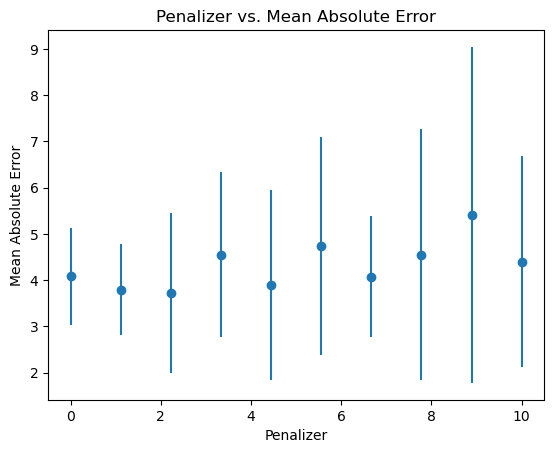

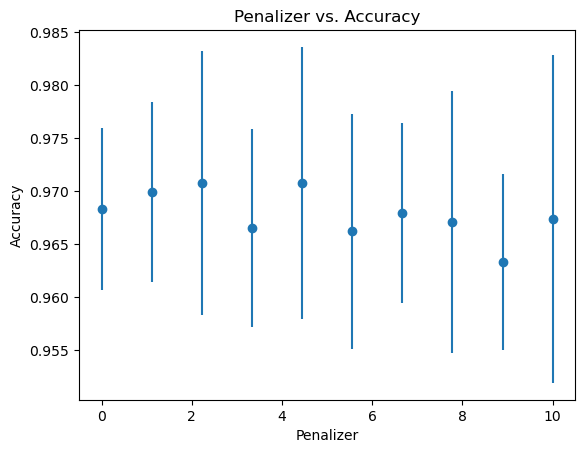

In [50]:
mean_errors = np.mean(errors, axis = 1)
std_errors = 1.65*np.std(errors, axis = 1)
plt.errorbar(penalizers, np.mean(errors, axis = 1), yerr=std_errors, fmt='o')
plt.title("Penalizer vs. Mean Absolute Error")
plt.xlabel("Penalizer")
plt.ylabel("Mean Absolute Error")
plt.show()

mean_accuracies = np.mean(accuracies, axis = 1)
std_accuracies = 1.65*np.std(accuracies, axis = 1)
plt.errorbar(penalizers, mean_accuracies, yerr=std_accuracies, fmt='o')
plt.title("Penalizer vs. Accuracy")
plt.xlabel("Penalizer")
plt.ylabel("Accuracy")
plt.show()